<a href="https://colab.research.google.com/github/akshnataraj/Pixel-by-pixel-classification/blob/main/MoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
flt_min = sys.float_info.min # to add a small float variable to avoid divide by zero errors.

### A.1) Helper functions to plot the numpy arrays as images

In [ ]:
def plot(im, gt, title1, title2, i):
    """
    a function that plots the original image and the ground truth image side by side, with it's corresponding titles
    
    Input parameters:
    im -- original RGB image
    gt -- ground truth binary mask
    
    Returns:
    None
    
    """
    fig = plt.figure(figsize=plt.figaspect(0.3))
    plt.subplot(1, 2, 1)
    plt.imshow(im)
    plt.gca().set_title(title1 + " - " + str(i+1))
    plt.subplot(1, 2, 2)
    plt.imshow(gt)
    plt.gca().set_title(title2 + " - " + str(i+1))
    
def plot_three(im, gt, posterior, i):
    """
    a function that plots the original image, the ground truth image and the posterior side by side, with it's corresponding titles
    
    Input parameters:
    im -- original RGB test image
    gt -- ground truth binary mask
    posterior -- posterior predictions based on im
    
    Returns:
    None
    
    """
    fig = plt.figure(figsize=plt.figaspect(0.3))
    plt.subplot(1, 3, 1)
    plt.imshow(im)
    plt.gca().set_title('Original Image' + " - " + str(i+1))
    plt.subplot(1, 3, 2)
    plt.imshow(posterior)
    plt.gca().set_title('Posterior' + " - " + str(i+1))
    plt.subplot(1, 3, 3)
    plt.imshow(gt)
    plt.gca().set_title('Ground Truth Binary mask' + " - " + str(i+1))
    

def threshold(gt):
    """ 
    a function that takes thresholds the ground truth image into 0s and 1s based on pixel value, 
    assigns 1 if pixel value >= 0.5 (1 denoting apple class)
    assigns 0 if pixel value < 0.5 (0 denoting non-apple class)
    
    Input parameters:
    gt -- ground truth image 
    
    Returns:
    gt -- thresholded ground truth image
    """
    gt[gt >= 0.5] = 1 # if pixel value is greater than 0.5 => assign 1
    gt[gt < 0.5] = 0 # if pixel value is less than 0 => assign 0
    return gt

### A.2) Displaying the training set

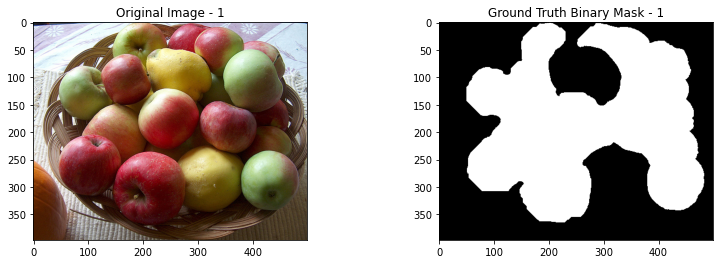

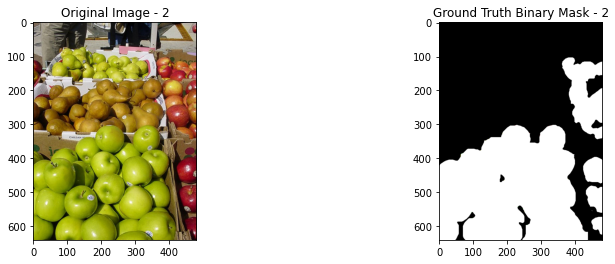

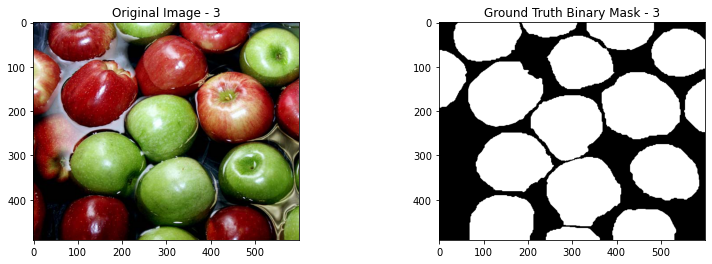

In [ ]:
img_files = glob.glob("apples/train/*.jpg")
gt_files = glob.glob("masks/train/*.png")
ColorImgs = []
GroundTruthImgs = []
for i in range(len(img_files)):
    im = plt.imread(img_files[i])
    gt = plt.imread(gt_files[i])
    ColorImgs.append(im) # contains all the RGB pixels of all train images
    gt = threshold(gt)
    GroundTruthImgs.append(gt) # contains all the ground truth pixels of all train images
    plot(im, gt, "Original Image", "Ground Truth Binary Mask", i)